In [ ]:
!pip install -U tensorboard_plugin_profile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q keras-tuner

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import os
import gc
import datetime
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Lambda, GlobalAveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from keras.utils import plot_model, to_categorical
import keras_tuner as kt
from keras.layers import Concatenate
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.nasnet import NASNetLarge, preprocess_input
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

<ipython-input-3-8ae00b713240>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
!nvidia-smi

Mon May 29 07:47:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# New Section

In [ ]:
# Check for GPU avvailability
print("GPU", "avaiable (YES!!!)" if tf.config.list_physical_devices("GPU") else "not avaiable") 

GPU avaiable (YES!!!)


In [ ]:
%cd /content/drive/MyDrive/Dog-vision

/content/drive/MyDrive/Dog-vision


#1 Load data

In [ ]:
data = pd.read_csv("labels.csv")
data

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]

In [ ]:
# Create filepaths from image's IDs
filepaths = []
id = data["id"]
for path in id:
  filepath = "./train/" + path +".jpg"
  filepaths.append(filepath)

In [ ]:
# Check whether number of filenames matches number of actual image files
if len(os.listdir("./train/")) == len(filepaths):
  print("Filepathss match actualy amount of files")
else:
  print("Filepathss do not match actualy amount of files, check the target directory.")

Filepathss match actualy amount of files


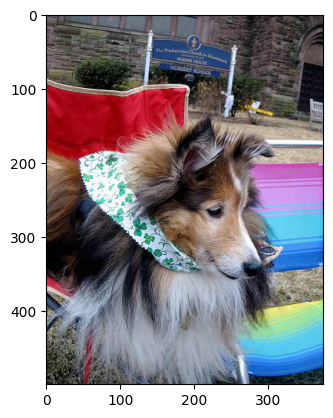

In [ ]:
image = plt.imread(filepaths[10])
plt.imshow(image)

#2 Exploratory Data Analysis (EDA)

In [ ]:
breeds = data["breed"]
breeds

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

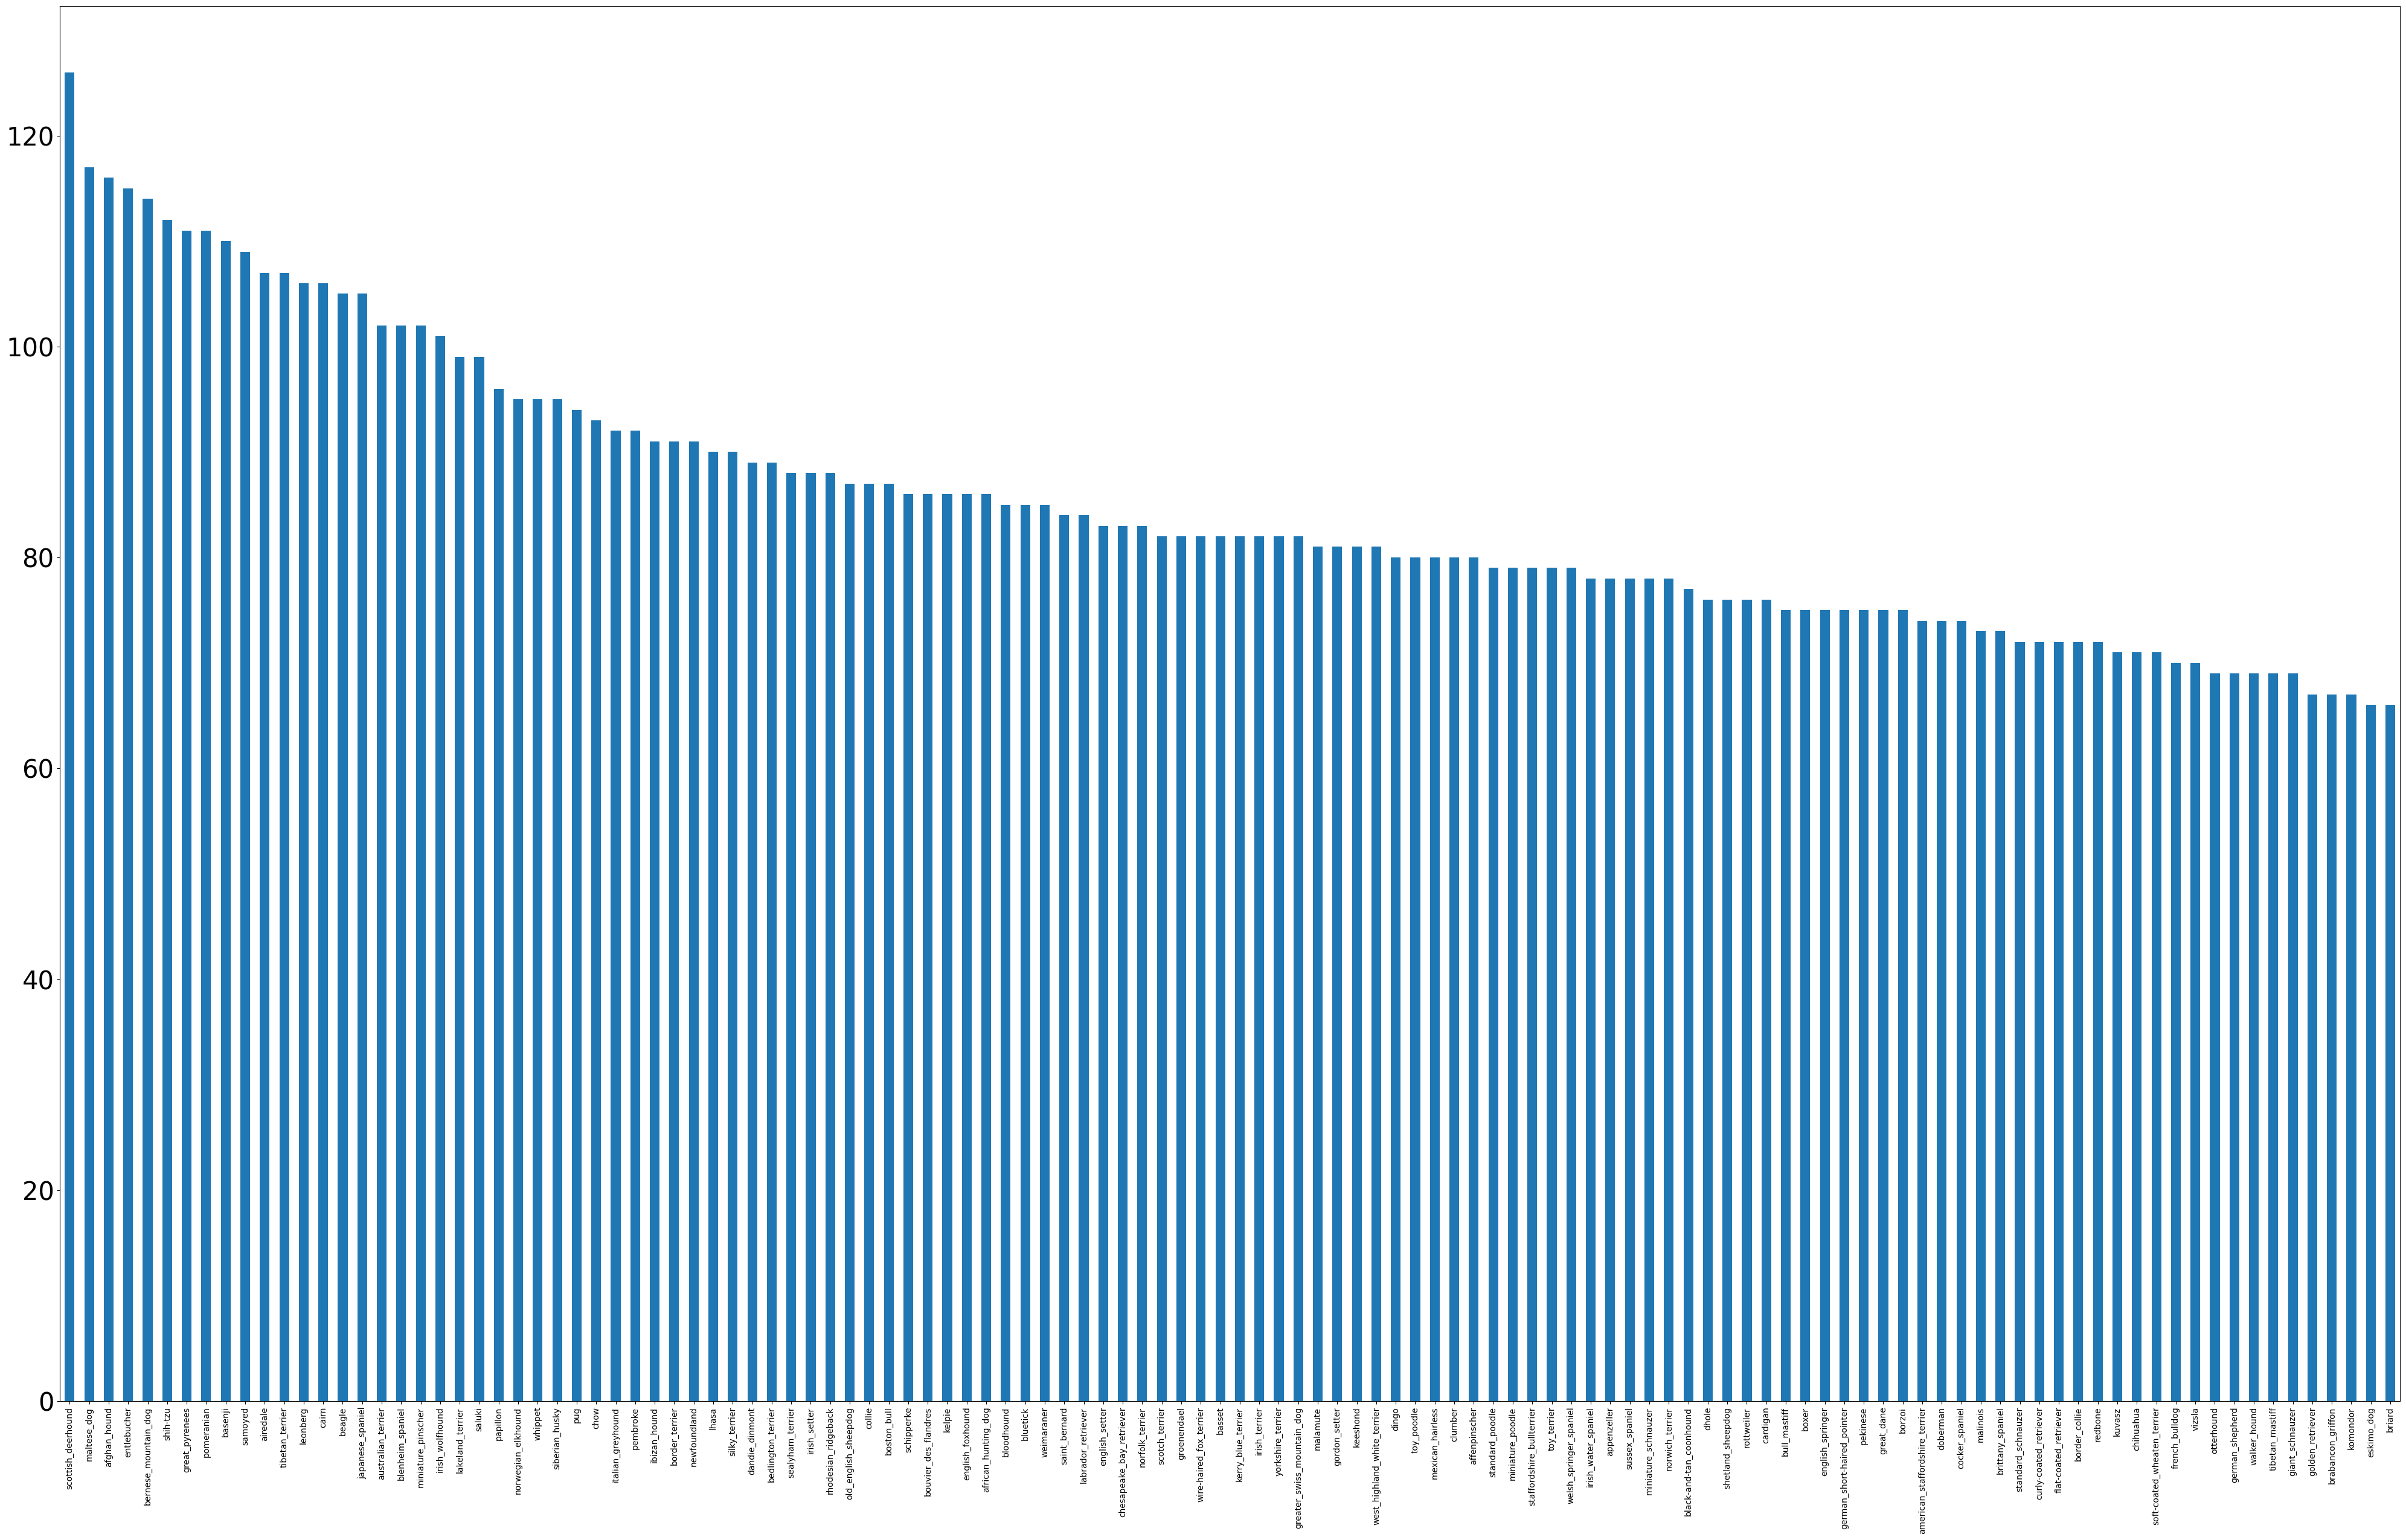

In [ ]:
# Chek how many images are there of these breed
breeds.value_counts().plot.bar(figsize=(50, 30))
plt.axis()
plt.yticks(fontsize=30)
plt.show()

In [ ]:
dog_breeds = np.unique(breeds)
dog_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
breeds.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [ ]:
# Check if number of labels matches the number of filenames
if len(breeds) == len(filepaths):
  print("Number of labels matches the number of filepaths")
else:
  print("Number of labels not matches number of the filepathss, check data directories")

Number of labels matches the number of filepaths


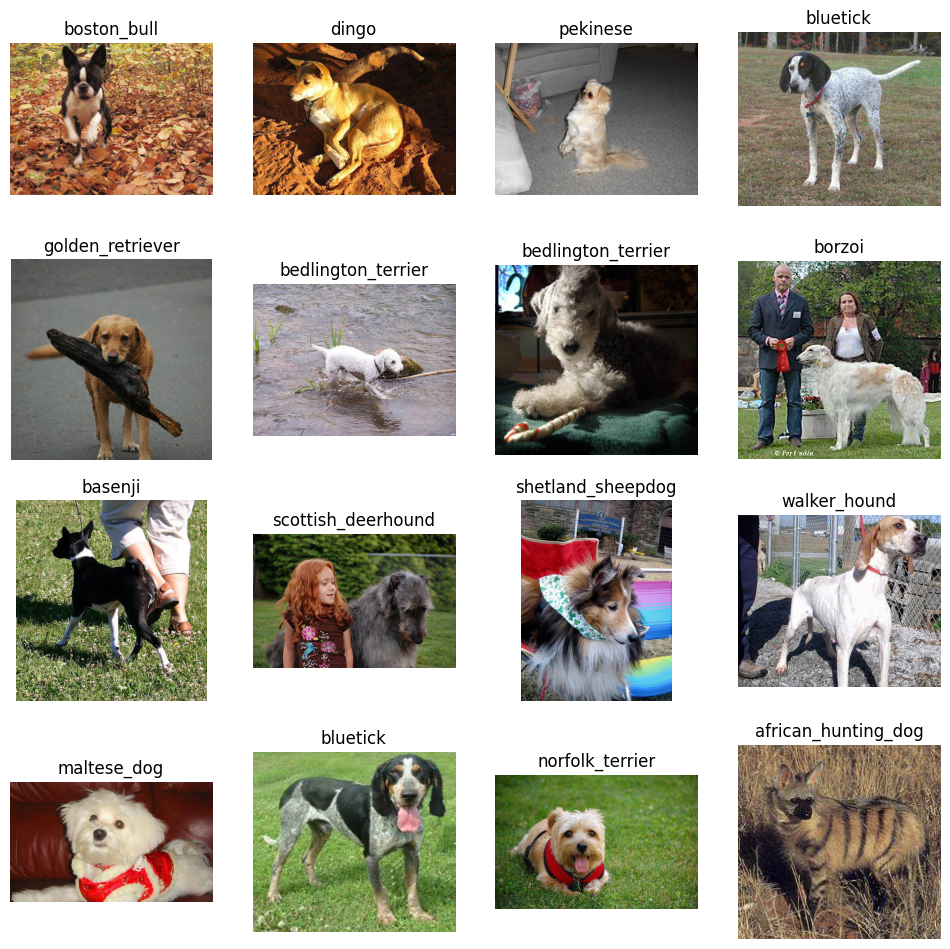

In [ ]:
# Visualizing 16 first image:
plt.figure(figsize=(12,12))
for idx, filepath in enumerate(filepaths[:16]):
  ax = plt.subplot(4, 4, idx+1)
  img = plt.imread(filepath)
  plt.imshow(img)
  plt.title(breeds[idx])
  plt.axis("off")

#3 Preprocessing data

In [ ]:
breeds[1] == dog_breeds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label to boolean array
labels = [breed == dog_breeds for breed in breeds]
len(labels[1]), labels[:3]

(120,
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False]),
  array([False, False, Fal

In [ ]:
# Turn labels form boolean array to integers array
labels = np.array(labels).astype(int)
labels.shape, labels

((10222, 120),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [ ]:
# Check a random label
idx = 288
print(labels[idx])
print(np.argmax(labels[idx]))
print(f"Label of idx {idx}: {dog_breeds[np.argmax(labels[idx])]}")

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
11
Label of idx 288: bernese_mountain_dog


## 3.1 Split data

In [ ]:
# Setup X,y variables
X = filepaths
y = labels
len(X), len(y)

(10222, 10222)

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 10222 #@param {type: "slider", min: 1000, max: 10222, step: 1000} 

In [ ]:
# Split data to train and valid sets
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES],test_size=0.2, random_state=56)
len(X_train), len(X_val), len(y_train), len(y_val)

(8177, 2045, 8177, 2045)

In [ ]:
X_train[1], y_train[1]

('./train/45c500a40d2bc460ed48337a8893ebc5.jpg',
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

## 3.2 Turning images into Tensors

In [ ]:
# Create a function to transform data to Tensors
IMG_SIZE = 224

def process_image(filepath, img_size=IMG_SIZE):

  # Read an image file
  image = tf.io.read_file(filepath)
  # Turn the image into numerical Tensor with 3 channel (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Normalization image by scaling to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize image
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [ ]:
# Create a simple function to return processed image and label
def get_image_label(image, label):
  image = process_image(image)
  
  return image, label

In [ ]:
# Test 2 function above
image_32, label_32 = get_image_label(filepaths[32], labels[32])
image_32, label_32

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[2.1821149e-02, 9.6624352e-02, 3.9579429e-02],
         [3.1774971e-01, 3.9849764e-01, 3.4007537e-01],
         [1.9432701e-02, 7.9156667e-02, 2.5785400e-02],
         ...,
         [0.0000000e+00, 2.8685225e-02, 7.3815696e-03],
         [1.9170513e-03, 4.3444425e-02, 1.0881329e-02],
         [1.4592139e-02, 6.1650965e-02, 2.2435278e-02]],
 
        [[1.0875124e-01, 1.8718261e-01, 1.4012378e-01],
         [1.7272735e-04, 4.8262980e-02, 1.3897762e-03],
         [6.4935260e-02, 1.2673499e-01, 8.3912849e-02],
         ...,
         [1.0160362e-04, 1.2352975e-02, 9.8086741e-05],
         [1.2390460e-02, 5.1494777e-02, 2.0159349e-02],
         [2.1063086e-02, 6.0197882e-02, 2.8852297e-02]],
 
        [[5.7045318e-02, 1.2597509e-01, 7.8916252e-02],
         [1.0413458e-02, 6.4111114e-02, 2.4974126e-02],
         [1.2249038e-02, 6.4907044e-02, 2.5636028e-02],
         ...,
         [2.1364415e-02, 4.3656677e-02, 1.5458719e-02],


In [ ]:
# Create a next function turn data into Datasets with specific batchsize
BATCH_SIZE = 32

def create_dataset(X, y=None, batch_size = BATCH_SIZE, val_data = False, test_data = False):

  # If the data is test data, we don't need the labels
  if test_data == True:
    print("Creating Test Dataset....")
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    dataset = dataset.map(process_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print("Creating Test Dataset completely")
    return dataset

  # If the data is valid data, we don't need to shuffle it
  elif val_data == True:
    print("Creating Validation Dataset...")
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    dataset = dataset.map(get_image_label).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print("Creating Validation Dataset completely")

    return dataset

  # If the data is train data, we will shuffle it
  else:
    print("Creating Train Dataset...")
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.map(get_image_label).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print("Creating Train Dataset completely")

    return dataset

In [ ]:
train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val, val_data = True)

Creating Train Dataset...
Creating Train Dataset completely
Creating Validation Dataset...
Creating Validation Dataset completely


In [ ]:
train_dataset, val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.int64, name=None))>)

In [ ]:
# Create a function to visualize 25 images whenever i want
def show_25_images(images, labels):

  plt.figure(figsize=(12, 12))
  for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(dog_breeds[labels[i].argmax()])
    plt.axis("off")

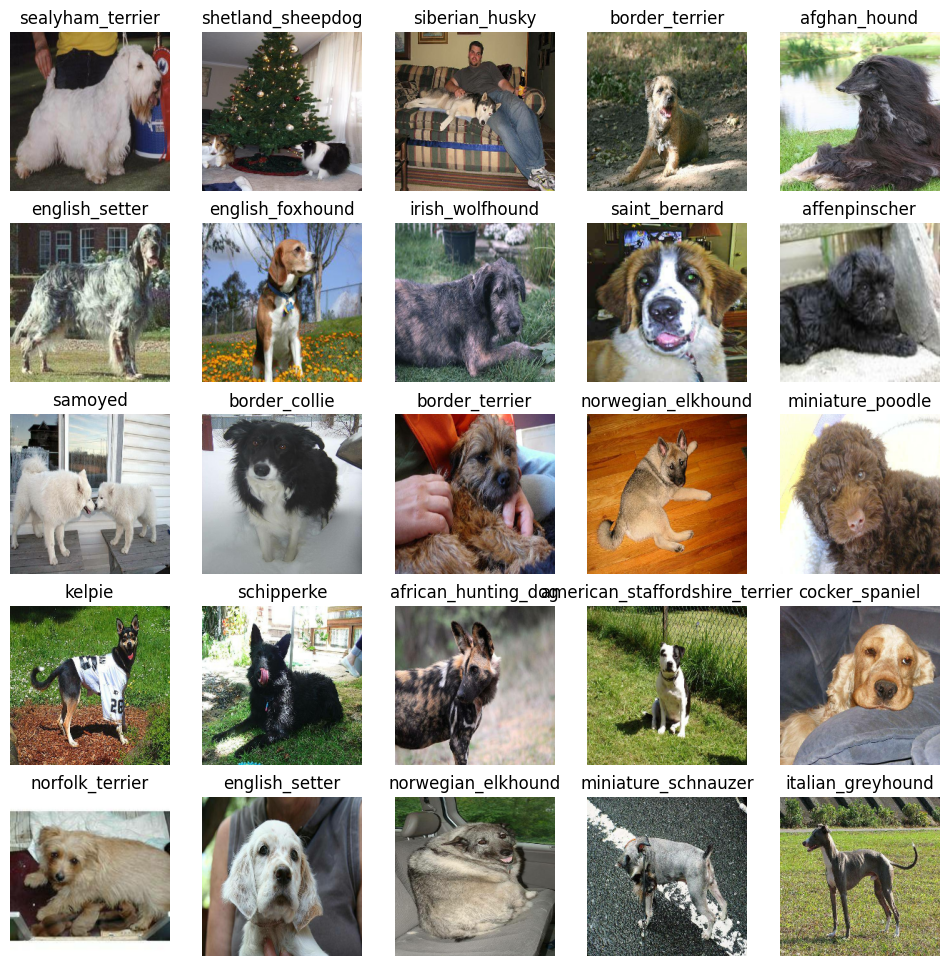

In [ ]:
# Check with train dataset
train_images, train_labels = train_dataset.as_numpy_iterator().next()
show_25_images(train_images, train_labels)

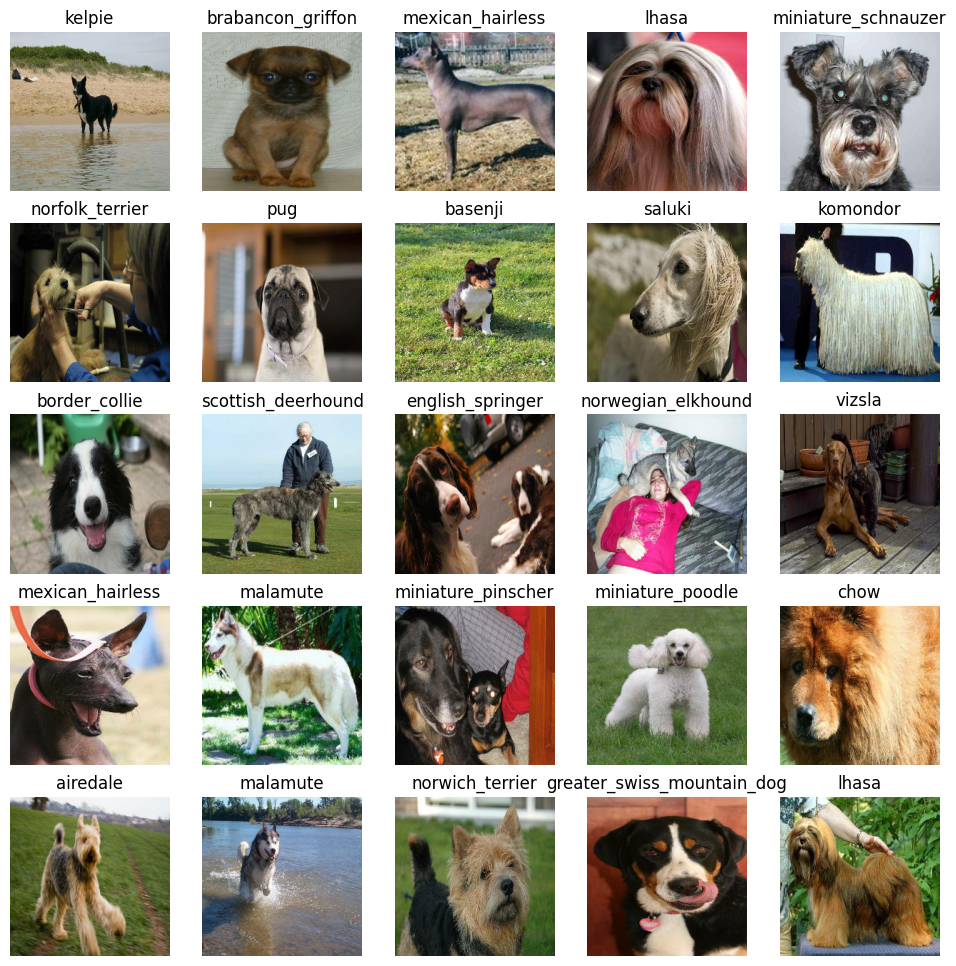

In [ ]:
# Check with validaton dataset
val_images, val_labels = val_dataset.as_numpy_iterator().next()
show_25_images(val_images, val_labels)

# 4 Build Model

##4.1 Build callback function

In [ ]:
# Create a function to build a TensorBoard callback
def create_tensorboard():
  log_dir = os.path.join("./logs2", datetime.datetime.now().strftime("%y%m%d-%H%M%S"))

  return TensorBoard(log_dir)

In [ ]:
# Create Earlystopping callback
early_stopping = EarlyStopping(monitor="val_accuracy", patience=5)

##4.2 Model 0: Mobilenet (mobilenet_v2_130_224)

### 4.2.1 Build Model

In [ ]:
# I will use pre-trained model MobileNetV2 from tensorflow hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [ ]:
# Setup the input vaf output shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SHAPE = len(dog_breeds)
# Build a function to create a model
def create_model(model_url = MODEL_URL, input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE):

  print("Building the model....")
  model = Sequential([
      hub.KerasLayer(MODEL_URL),

      # Dense(224, activation = "relu"),
      # BatchNormalization(),
      # Dropout(0.4),

      Dense(units=OUTPUT_SHAPE, activation="softmax")
])

  model.build(INPUT_SHAPE)
  print("Building the model completely")
  return model

In [ ]:
model = create_model()
model.summary()

Building the model....
Building the model completely
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_3 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [ ]:
EPOCHS = 10 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Check to make sure we are still running on a GPU
print("GPU avaiable" if tf.config.list_physical_devices("GPU") else "not avaiable")

GPU avaiable


In [ ]:
model.compile(optimizer = Adam(learning_rate=0.001),
              loss = CategoricalCrossentropy(),
              metrics = ["accuracy"])

In [ ]:
# tensorboard = create_tensorboard()
model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset,
          callbacks=[early_stopping], verbose=1)

Epoch 1/10
 10/256 [>.............................] - ETA: 40:43 - loss: 5.4489 - accuracy: 0.0156

KeyboardInterrupt: ignored

In [ ]:
# # Load TensorBoard notebook extension
# %load_ext tensorboard
# %tensorboard --logdir = ./logs

###4.2.2 Hypertuning

In [ ]:
pwd

In [ ]:
# Create a Keras tuner
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"
IMG_SIZE = 224
INPUT_SHAPE = [IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SHAPE = len(dog_breeds)

def build_model(hp):

  input_layer = Input(shape=INPUT_SHAPE)
  x = hub.KerasLayer(MODEL_URL)(input_layer)
  x = Dense(hp.Int("dense_units", min_value=32, max_value=256, step=32))(x)
  x = BatchNormalization()(x)
  x = Dropout(hp.Float("dropout", min_value=0.2, max_value=0.6, step=0.1))(x)
  output_layer = Dense(units=OUTPUT_SHAPE, activation="softmax")(x)

  model_0 = Model(inputs=input_layer, outputs=output_layer)
  
  model_0.compile(optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
              loss = CategoricalCrossentropy(),
              metrics = ["accuracy"])
  
  return model_0

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20)

In [ ]:
EPOCHS = 10
results = tuner.search(train_dataset, epochs=EPOCHS, validation_data=val_dataset, verbose=1)

In [ ]:
best_model = tuner.get_best_models()
best_model

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters()
best_hyperparameters

In [ ]:
for idx, model in enumerate(best_model):
    print(f"\nBest model {idx + 1} hyperparameters:")
    for hp_name, hp_value in best_hyperparameters[idx].values.items():
        print(f"{hp_name}: {hp_value}")